A Stock Price Predictor based on LSTM model.

Importing the libraries

In [152]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

Downloading the data and checking if the correct data is downloaded

In [153]:
print("Downloading data...")
raw = yf.download('AAPL', start='2015-01-01', end='2024-12-31')
raw = raw[['Open', 'High', 'Low', 'Close', 'Volume']]

# Clean column names if multi-index
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Add basic technical indicators
raw['SMA_20'] = raw['Close'].rolling(window=20).mean()
raw['EMA_20'] = raw['Close'].ewm(span=20).mean()
raw['RSI_14'] = ta.momentum.RSIIndicator(close=raw['Close'], window=14).rsi()

# KEY CHANGE: Create price differences (returns) instead of absolute prices
raw['Close_diff'] = raw['Close'].diff()
raw['Close_pct'] = raw['Close'].pct_change()  # Alternative: percentage returns

# Drop NaN rows
raw = raw.dropna()
print(f"Data shape after cleaning: {raw.shape}")

# === 2. PREPARE FEATURES FOR MODELING ===
# We'll predict Close_diff (price changes) instead of absolute prices
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'Close_diff']
raw_features = raw[feature_columns].copy()

print("Feature columns:", feature_columns)
target_column = 'Close_diff'
target_idx = feature_columns.index(target_column)
close_idx = feature_columns.index('Close')  # We'll need this for reconstruction

[*********************100%***********************]  1 of 1 completed

Data shape after cleaning: (2496, 10)
Feature columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'Close_diff']


Plotting the data

Preprocessing of data by normalizing it. Only using closing price for now. 

In [154]:
n = len(raw_features)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

train_df = raw_features.iloc[:train_size].copy()
val_df = raw_features.iloc[train_size:train_size + val_size].copy()
test_df = raw_features.iloc[train_size + val_size:].copy()

print(f"Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

# === 4. SCALING (FIT ONLY ON TRAIN) ===
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

Train: (1747, 9), Val: (374, 9), Test: (375, 9)


Creating time series sequences for prediction. We will use past 60 days for now.

In [155]:
def create_sequences(data, seq_len, target_idx):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])  # Past seq_len days of all features
        y.append(data[i, target_idx])  # Target: Close_diff for day i
    return np.array(X), np.array(y)

sequence_length = 30  # Shorter sequence
X_train, y_train = create_sequences(train_scaled, sequence_length, target_idx)
X_val, y_val = create_sequences(val_scaled, sequence_length, target_idx)
X_test, y_test = create_sequences(test_scaled, sequence_length, target_idx)

print(f"Sequence shapes - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, X_test: {X_test.shape}")

Sequence shapes - X_train: (1717, 30, 9), y_train: (1717,)
X_val: (344, 30, 9), X_test: (345, 30, 9)


Splitting data into testing and training data

Model summary:


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_35 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921 (23.13 KB)

 Trainable params: 5,921 (23.13 KB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1097 - mae: 0.2787 - val_loss: 0.0374 - val_mae: 0.1548
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0479 - mae: 0.1764 - val_loss: 0.0263 - val_mae: 0.1266
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0406 - mae: 0.1606 - val_loss: 0.0277 - val_mae: 0.1300
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0306 - mae: 0.1411 - val_loss: 0.0284 - val_mae: 0.1321
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253 - mae: 0.1284 - val_loss: 0.0280 - val_mae: 0.1312
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - mae: 0.1205 - val_loss: 0.0265 - val_mae: 0.1270
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0196 - mae: 0.1100 - val_loss: 0.0260 - val_mae: 0.1256
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0192 - mae: 0.1098 - val_loss: 0.0243 - val_mae: 0.1209
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - lo

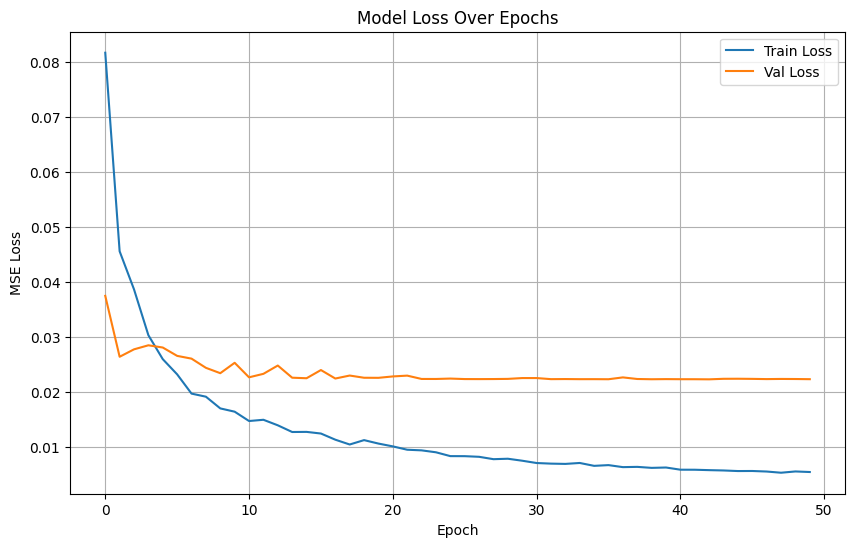

In [156]:
model = Sequential([
    LSTM(units=32, input_shape=(sequence_length, len(feature_columns)), 
         return_sequences=False),
    Dropout(0.4),
    Dense(units=16, activation='relu'),
    Dropout(0.3),
    Dense(units=1)
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='mean_squared_error',
    metrics=['mae']
)

print("Model summary:")
model.summary()
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# === 8. PLOT TRAINING HISTORY ===
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


Making predictions...
Prediction shapes - pred_prices: (345,), true_prices: (345,)

=== RESULTS ===
Test Set RMSE: 2.71
Test Set MAE: 2.00
Test Set MAPE: 1.01%
Mean Actual Price: 199.25


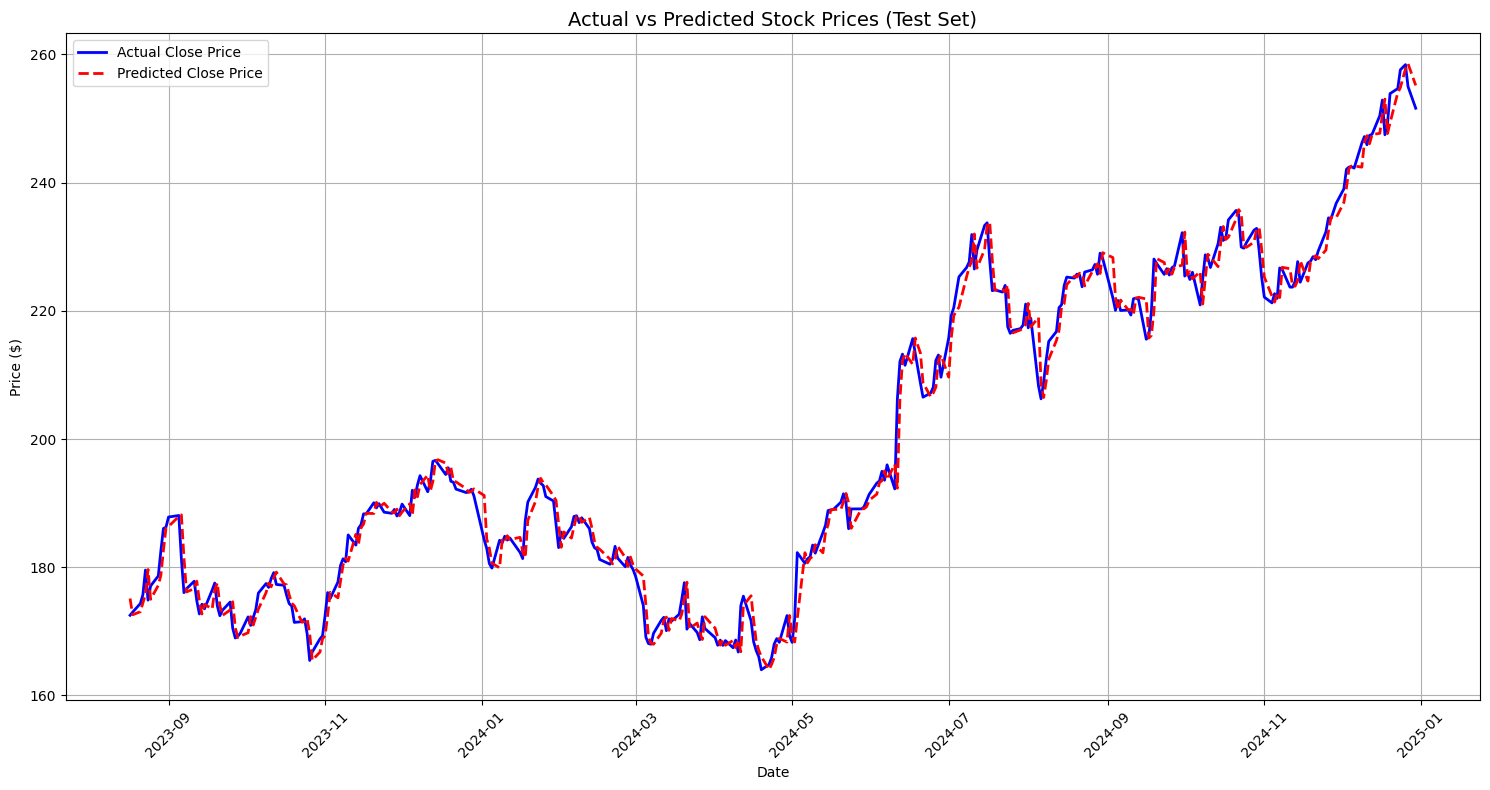

In [158]:
print("Making predictions...")

# Get scaled predictions (these are Close_diff predictions)
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse transform the differences
dummy_pred = np.zeros((len(y_pred_scaled), len(feature_columns)))
dummy_pred[:, target_idx] = y_pred_scaled.flatten()
pred_diff_unscaled = scaler.inverse_transform(dummy_pred)[:, target_idx]

dummy_true = np.zeros((len(y_test), len(feature_columns)))
dummy_true[:, target_idx] = y_test.flatten()
true_diff_unscaled = scaler.inverse_transform(dummy_true)[:, target_idx]

# CRITICAL: Reconstruct actual prices from differences
# We need the 'Close' price from the day before each prediction
# Get the last 'Close' price from each sequence in X_test
last_close_scaled = X_test[:, -1, close_idx]  # Last day's close price from each sequence

# Unscale these close prices
dummy_close = np.zeros((len(last_close_scaled), len(feature_columns)))
dummy_close[:, close_idx] = last_close_scaled
last_close_unscaled = scaler.inverse_transform(dummy_close)[:, close_idx]

# Reconstruct predicted prices: previous_close + predicted_difference
pred_prices = last_close_unscaled + pred_diff_unscaled

# For true prices, get them directly from the original test data
test_start_idx = train_size + val_size + sequence_length
true_prices = raw['Close'].iloc[test_start_idx:test_start_idx + len(pred_prices)].values

print(f"Prediction shapes - pred_prices: {pred_prices.shape}, true_prices: {true_prices.shape}")

# === 10. EVALUATE AND PLOT ===
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = np.mean(np.abs(true_prices - pred_prices))
mape = np.mean(np.abs((true_prices - pred_prices) / true_prices)) * 100

print(f"\n=== RESULTS ===")
print(f"Test Set RMSE: {rmse:.2f}")
print(f"Test Set MAE: {mae:.2f}")
print(f"Test Set MAPE: {mape:.2f}%")
print(f"Mean Actual Price: {np.mean(true_prices):.2f}")

# Get corresponding dates for plotting
test_dates = raw.index[test_start_idx:test_start_idx + len(pred_prices)]

plt.figure(figsize=(15, 8))
plt.plot(test_dates, true_prices, label='Actual Close Price', color='blue', linewidth=2)
plt.plot(test_dates, pred_prices, label='Predicted Close Price', color='red', 
         linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Stock Prices (Test Set)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



New code for tomorrow's price

In [160]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def predict_any_date_realistically(model, scaler, target_date, symbol='NDAQ', sequence_length=30):
    """
    Predict stock price for any date using only data available up to that point.
    This simulates making a real prediction on that historical date.
    """
    
    # Convert target_date to datetime
    if isinstance(target_date, str):
        target_date = datetime.strptime(target_date, '%Y-%m-%d')
    
    print(f"🎯 Predicting {symbol} price for: {target_date.strftime('%A, %B %d, %Y')}")
    print(f"📅 Using only data available up to: {(target_date - timedelta(days=1)).strftime('%Y-%m-%d')}")
    
    # === STEP 1: Download data only up to the day BEFORE target date ===
    cutoff_date = target_date - timedelta(days=1)
    
    print("📊 Downloading historical market data...")
    historical_data = yf.download(symbol, start='2015-01-01', end=cutoff_date.strftime('%Y-%m-%d'))
    
    if historical_data.empty:
        raise ValueError("No historical data available for this date range.")
    
    historical_data = historical_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Clean column names
    if isinstance(historical_data.columns, pd.MultiIndex):
        historical_data.columns = historical_data.columns.get_level_values(0)
    
    # Add features using only historical data
    historical_data['SMA_20'] = historical_data['Close'].rolling(window=20).mean()
    historical_data['EMA_20'] = historical_data['Close'].ewm(span=20).mean()
    historical_data['RSI_14'] = ta.momentum.RSIIndicator(close=historical_data['Close'], window=14).rsi()
    historical_data['Close_diff'] = historical_data['Close'].diff()
    historical_data = historical_data.dropna()
    
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'Close_diff']
    
    print(f"📈 Latest historical data: {historical_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"🔍 Making prediction for: {target_date.strftime('%Y-%m-%d')}")
    
    if len(historical_data) < sequence_length:
        raise ValueError(f"Need at least {sequence_length} days of historical data. Got {len(historical_data)}")
    
    # === STEP 2: Make prediction using historical data ===
    input_data = historical_data[feature_columns].tail(sequence_length)
    input_scaled = scaler.transform(input_data)
    X_predict = input_scaled.reshape(1, sequence_length, len(feature_columns))
    
    # Make prediction for price difference
    predicted_diff_scaled = model.predict(X_predict, verbose=0)
    
    # Convert back to actual difference
    dummy_pred = np.zeros((1, len(feature_columns)))
    dummy_pred[0, feature_columns.index('Close_diff')] = predicted_diff_scaled[0, 0]
    predicted_diff_actual = scaler.inverse_transform(dummy_pred)[0, feature_columns.index('Close_diff')]
    
    # Calculate predicted price
    last_known_price = historical_data['Close'].iloc[-1]
    predicted_price = last_known_price + predicted_diff_actual
    
    print(f"   Last known price ({historical_data.index[-1].strftime('%Y-%m-%d')}): ${last_known_price:.2f}")
    print(f"   Predicted change: ${predicted_diff_actual:+.2f}")
    print(f"   Predicted price: ${predicted_price:.2f}")
    
    # === STEP 3: Get actual outcome for comparison (FIXED) ===
    actual_price = None
    prediction_error = None
    percentage_error = None
    
    try:
        # Download data that includes the target date to get actual outcome
        verification_start = target_date - timedelta(days=2)
        verification_end = target_date + timedelta(days=5)
        
        actual_data = yf.download(symbol, 
                                start=verification_start.strftime('%Y-%m-%d'), 
                                end=verification_end.strftime('%Y-%m-%d'))
        
        if not actual_data.empty and 'Close' in actual_data.columns:
            # Clean column names if multi-index
            if isinstance(actual_data.columns, pd.MultiIndex):
                actual_data.columns = actual_data.columns.get_level_values(0)
            
            # Convert target date to string for comparison
            target_date_str = target_date.strftime('%Y-%m-%d')
            
            # Find the closest trading day to our target date
            actual_data_dates = [d.strftime('%Y-%m-%d') for d in actual_data.index]
            
            if target_date_str in actual_data_dates:
                # Exact date found
                actual_price = actual_data.loc[actual_data.index.strftime('%Y-%m-%d') == target_date_str, 'Close'].iloc[0]
                used_date = target_date_str
            else:
                # Target date was weekend/holiday, find next trading day
                future_dates = [d for d in actual_data_dates if d > target_date_str]
                if future_dates:
                    used_date = future_dates[0]
                    actual_price = actual_data.loc[actual_data.index.strftime('%Y-%m-%d') == used_date, 'Close'].iloc[0]
                    print(f"   📅 Target date was non-trading day, using next trading day: {used_date}")
                else:
                    raise ValueError("No trading day found after target date")
            
            if actual_price is not None:
                prediction_error = predicted_price - actual_price
                percentage_error = (prediction_error / actual_price) * 100
                
                print(f"   🎯 Actual price: ${actual_price:.2f}")
                print(f"   📊 Prediction error: ${prediction_error:+.2f} ({percentage_error:+.2f}%)")
                
                # Color code the result
                if abs(percentage_error) < 2:
                    status = "🎉 Excellent prediction!"
                elif abs(percentage_error) < 5:
                    status = "✅ Good prediction!"
                elif abs(percentage_error) < 10:
                    status = "⚠️ Reasonable prediction"
                else:
                    status = "❌ Poor prediction"
                
                print(f"   {status}")
            
    except Exception as e:
        print(f"   ℹ️ Could not retrieve actual price for comparison: {str(e)}")
    
    return {
        'target_date': target_date.strftime('%Y-%m-%d'),
        'predicted_price': predicted_price,
        'predicted_change': predicted_diff_actual,
        'last_known_price': last_known_price,
        'last_known_date': historical_data.index[-1].strftime('%Y-%m-%d'),
        'actual_price': actual_price,
        'prediction_error': prediction_error,
        'percentage_error': percentage_error,
        'prediction_type': 'realistic_historical' if actual_price else 'future'
    }

def backtest_multiple_dates(model, scaler, start_date, end_date, symbol='NVDA', frequency_days=7):
    """
    Backtest the model on multiple historical dates
    """
    print(f"🔍 Backtesting {symbol} from {start_date} to {end_date}")
    print(f"📅 Testing every {frequency_days} days")
    
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    results = []
    current_date = start_dt
    
    while current_date <= end_dt:
        try:
            print(f"\n--- Testing {current_date.strftime('%Y-%m-%d')} ---")
            result = predict_any_date_realistically(model, scaler, current_date, symbol)
            if result['actual_price'] is not None:
                results.append(result)
        except Exception as e:
            print(f"❌ {current_date.strftime('%Y-%m-%d')}: Error - {str(e)}")
        
        current_date += timedelta(days=frequency_days)
    
    # Calculate overall statistics
    if results:
        errors = [abs(r['percentage_error']) for r in results if r['percentage_error'] is not None]
        if errors:
            avg_error = np.mean(errors)
            median_error = np.median(errors)
            
            print(f"\n" + "="*50)
            print(f"📊 BACKTEST RESULTS:")
            print(f"   Total predictions: {len(results)}")
            print(f"   Average absolute error: {avg_error:.2f}%")
            print(f"   Median absolute error: {median_error:.2f}%")
            print(f"   Best prediction: {min(errors):.2f}%")
            print(f"   Worst prediction: {max(errors):.2f}%")
            
            # Count good predictions
            excellent = sum(1 for e in errors if e < 2)
            good = sum(1 for e in errors if 2 <= e < 5)
            reasonable = sum(1 for e in errors if 5 <= e < 10)
            poor = sum(1 for e in errors if e >= 10)
            
            print(f"   Excellent (<2%): {excellent} ({excellent/len(errors)*100:.1f}%)")
            print(f"   Good (2-5%): {good} ({good/len(errors)*100:.1f}%)")
            print(f"   Reasonable (5-10%): {reasonable} ({reasonable/len(errors)*100:.1f}%)")
            print(f"   Poor (>10%): {poor} ({poor/len(errors)*100:.1f}%)")
    
    return results

# Simple wrapper functions
def predict_today():
    """Predict today's closing price using only data up to yesterday"""
    today = datetime.now()
    return predict_any_date_realistically(model, scaler, today)

def predict_yesterday():
    """Predict yesterday's closing price and compare to actual"""
    yesterday = datetime.now() - timedelta(days=1)
    return predict_any_date_realistically(model, scaler, yesterday)

def predict_historical_date(date_str):
    """Predict any historical date as if you were on that day"""
    return predict_any_date_realistically(model, scaler, date_str)

# Quick test function
def quick_test():
    """Quick test of recent predictions"""
    print("🧪 QUICK TEST - Recent Predictions")
    print("="*40)
    
    test_dates = [
        '2025-05-22',  # Yesterday
        '2025-05-21',  # Day before yesterday  
        '2025-05-20',  # Earlier this week
    ]
    
    for date in test_dates:
        try:
            print(f"\n📅 Testing {date}:")
            result = predict_historical_date(date)
            if result and result['actual_price']:
                error = abs(result['percentage_error'])
                print(f"   ✅ Success! Error: {error:.2f}%")
            else:
                print(f"   ⚠️ No actual data available for comparison")
        except Exception as e:
            print(f"   ❌ Error: {str(e)}")


In [161]:
# predict_today()

predict_historical_date('2025-05-23')

🎯 Predicting NDAQ price for: Friday, May 23, 2025
📅 Using only data available up to: 2025-05-22
📊 Downloading historical market data...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

📈 Latest historical data: 2025-05-21
🔍 Making prediction for: 2025-05-23
   Last known price (2025-05-21): $80.64
   Predicted change: $+0.01
   Predicted price: $80.65
   🎯 Actual price: $81.78
   📊 Prediction error: $-1.13 (-1.38%)
   🎉 Excellent prediction!


{'target_date': '2025-05-23',
 'predicted_price': np.float64(80.65484802014271),
 'predicted_change': np.float64(0.014848630494271554),
 'last_known_price': np.float64(80.63999938964844),
 'last_known_date': '2025-05-21',
 'actual_price': np.float64(81.77999877929688),
 'prediction_error': np.float64(-1.1251507591541667),
 'percentage_error': np.float64(-1.3758263340045511),
 'prediction_type': 'realistic_historical'}